In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import random


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8   # important for small medical dataset

train_dir = "/content/drive/MyDrive/Epilepsy_preprocess_MRI/train"
val_dir = "/content/drive/MyDrive/Epilepsy_preprocess_MRI/test"

CLASS_ORDER = ["epilepsy ", "healthy "]

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    class_names=CLASS_ORDER
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    class_names=CLASS_ORDER,
    shuffle=False
)

# ✅ PRINT HERE
print("Class order:", train_data.class_names)

# Then optimize pipeline
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.shuffle(500).cache().prefetch(AUTOTUNE)
val_data = val_data.cache().prefetch(AUTOTUNE)


Found 560 files belonging to 2 classes.
Found 140 files belonging to 2 classes.
Class order: ['epilepsy ', 'healthy ']


In [ ]:
def get_aug():
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.1),
    ])


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=5,
        factor=0.3
    )
]


In [ ]:
def build_cnn():
    aug = get_aug()

    inputs = layers.Input(shape=(224,224,3))
    x = aug(inputs)

    x = layers.Conv2D(32,3,activation="relu",padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64,3,activation="relu",padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128,3,activation="relu",padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128,activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1,activation="sigmoid")(x)

    return models.Model(inputs,outputs)


cnn_model = build_cnn()
cnn_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

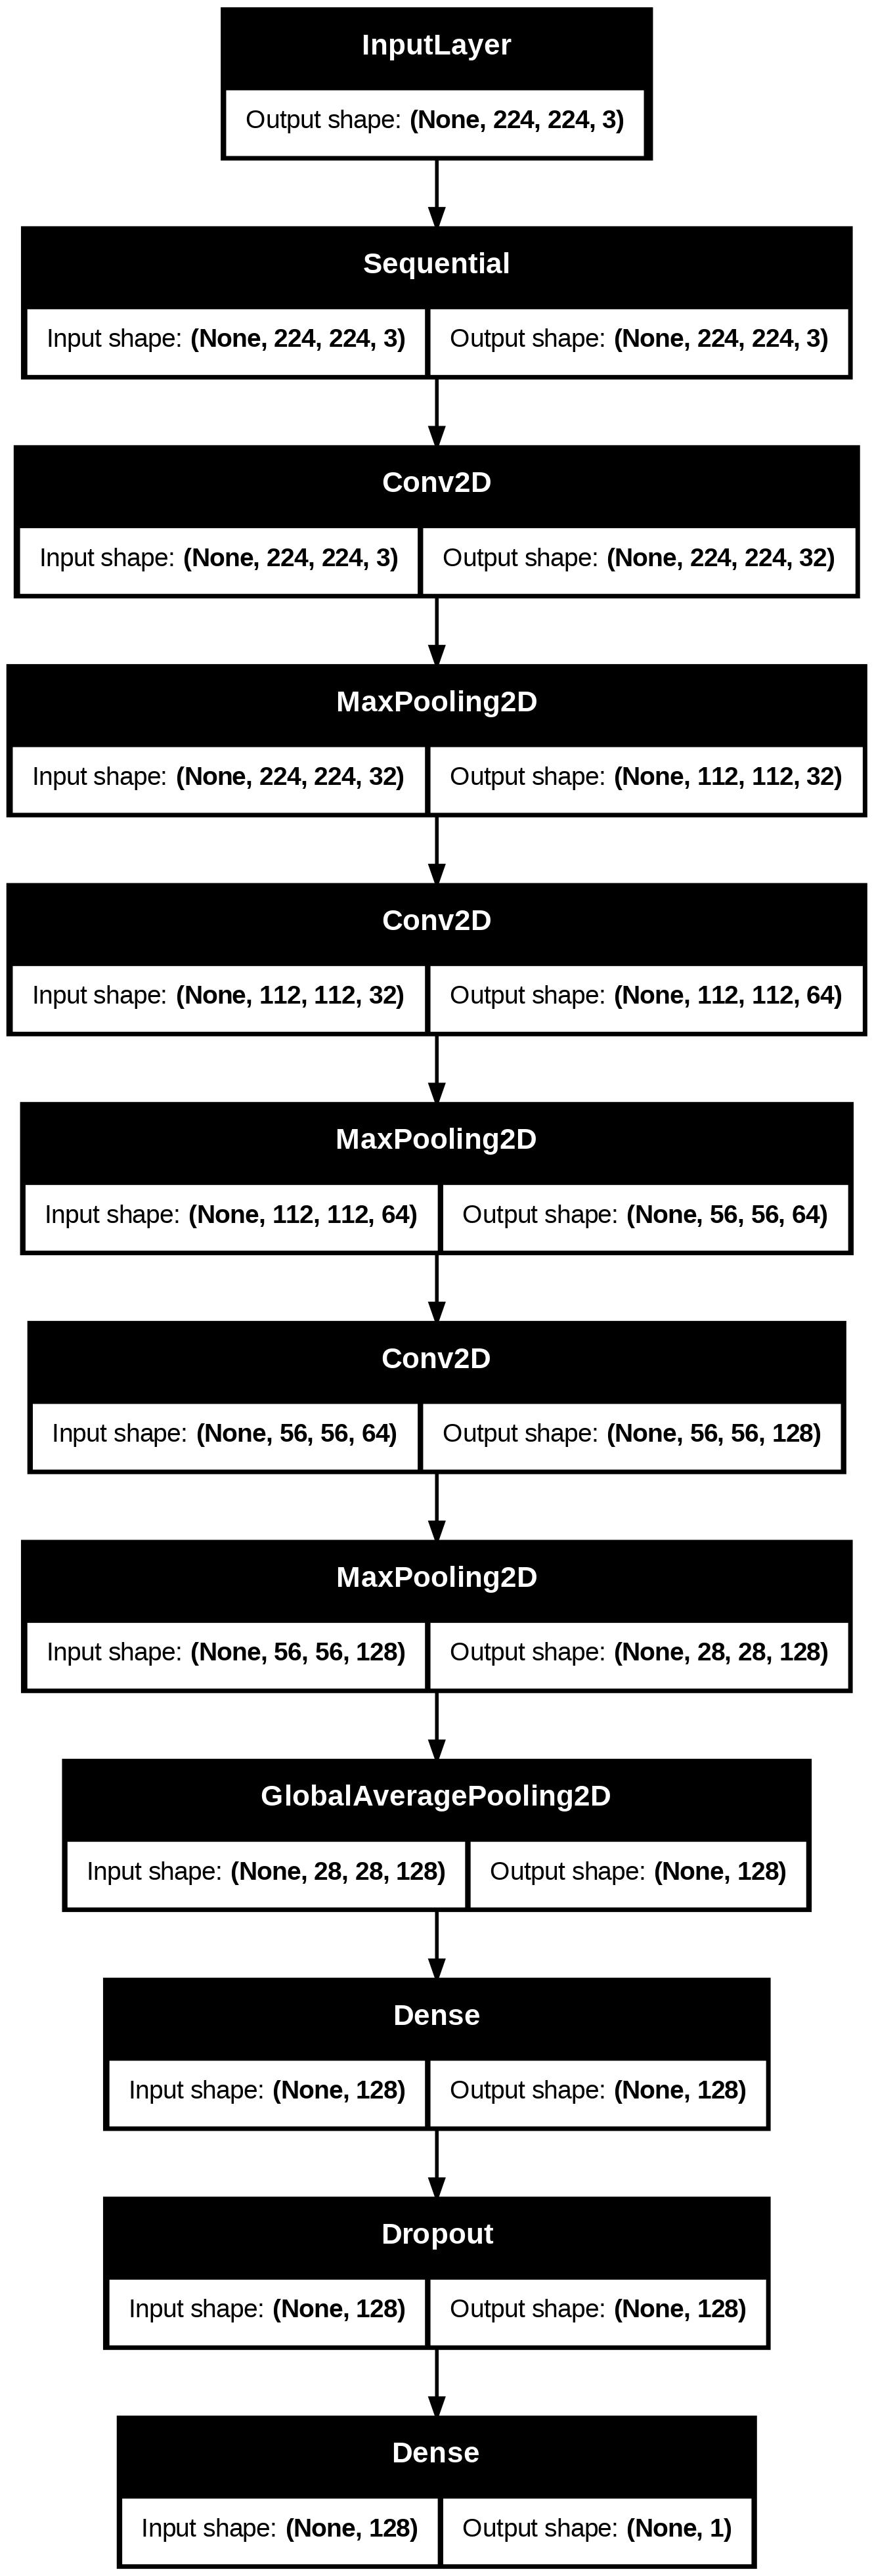

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)


In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



In [ ]:

history_cnn = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6567 - loss: 0.5835 - val_accuracy: 0.7857 - val_loss: 0.4726 - learning_rate: 1.0000e-04
Epoch 2/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6988 - loss: 0.5664 - val_accuracy: 0.8071 - val_loss: 0.4567 - learning_rate: 1.0000e-04
Epoch 3/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6870 - loss: 0.5558 - val_accuracy: 0.7857 - val_loss: 0.4836 - learning_rate: 1.0000e-04
Epoch 4/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7332 - loss: 0.5058 - val_accuracy: 0.7714 - val_loss: 0.4961 - learning_rate: 1.0000e-04
Epoch 5/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6999 - loss: 0.5501 - val_accuracy: 0.8000 - val_loss: 0.4518 - learning_rate: 1.0000e-04
Epoch 6/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7497 - loss: 0.5207 - val_accuracy: 0.8286 - val_loss: 0.4455 - learning_rate: 1.0000e-04
Epoch 7/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7510 

In [ ]:
print("CNN best epoch:", np.argmin(history_cnn.history["val_loss"]) + 1)


CNN best epoch: 6


In [ ]:
def residual_block(x, f):
    s = x

    x = layers.Conv2D(f,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(f,3,padding="same")(x)
    x = layers.BatchNormalization()(x)

    if s.shape[-1] != f:
        s = layers.Conv2D(f,1,padding="same")(s)

    x = layers.Add()([x,s])
    return layers.Activation("relu")(x)


def build_residual():
    aug = get_aug()

    inputs = layers.Input(shape=(224,224,3))
    x = aug(inputs)

    x = layers.Conv2D(32,3,padding="same")(x)

    x = residual_block(x,32)
    x = layers.MaxPooling2D()(x)

    x = residual_block(x,64)
    x = layers.MaxPooling2D()(x)

    x = residual_block(x,128)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256,activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1,activation="sigmoid")(x)

    return models.Model(inputs,outputs)


res_model = build_residual()
res_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │        896 │ sequential_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │      9,248 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 224, 224,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 112, 112,  │      2,112 │ max_pooling2d_3[

 Total params: 341,761 (1.30 MB)

 Trainable params: 340,865 (1.30 MB)

 Non-trainable params: 896 (3.50 KB)

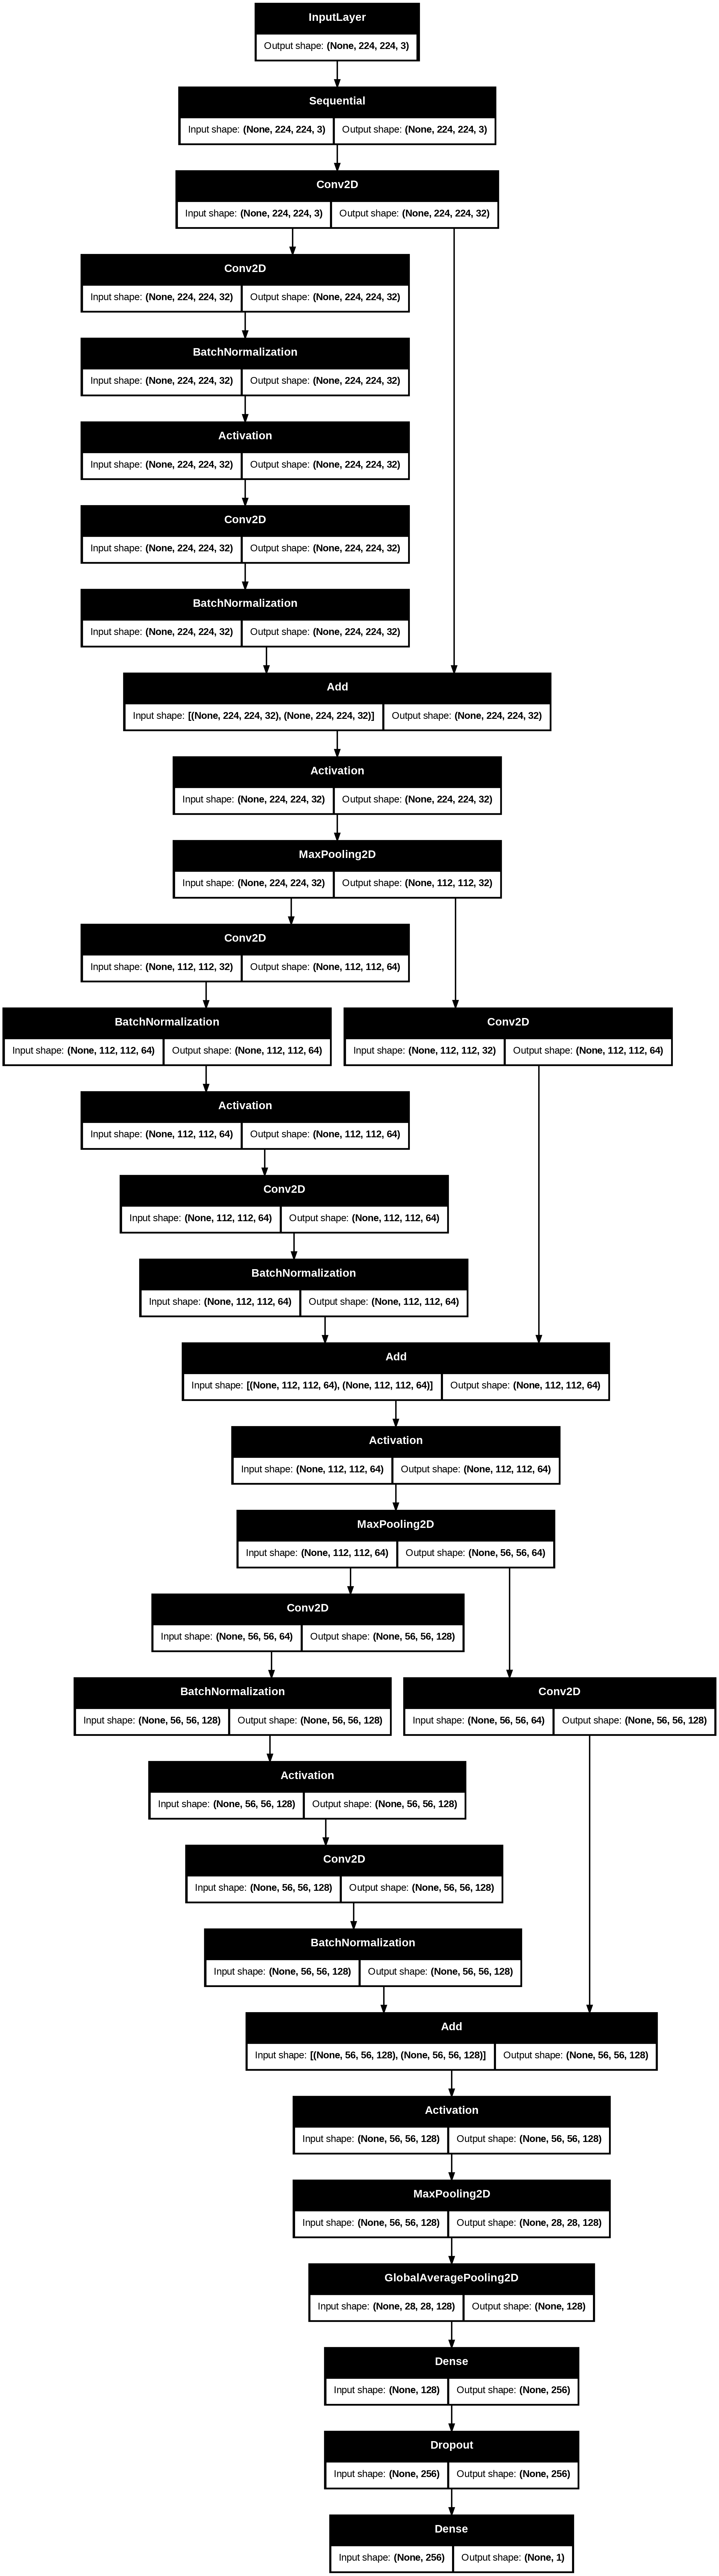

In [ ]:
tf.keras.utils.plot_model(res_model, show_shapes=True)

In [ ]:
res_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:

history_res = res_model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=callbacks
)




Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.5063 - loss: 3.7304 - val_accuracy: 0.5500 - val_loss: 1.2241 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.5466 - loss: 2.6386 - val_accuracy: 0.5929 - val_loss: 0.7603 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.5856 - loss: 1.4774 - val_accuracy: 0.5357 - val_loss: 1.1024 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.5797 - loss: 1.2484 - val_accuracy: 0.5143 - val_loss: 1.0152 - learning_rate: 1.0000e-04
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.5585 - loss: 1.0446 - val_accuracy: 0.7214 - val_loss: 0.5307 - learning_rate: 1.0000e-04
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.6122 - loss: 0.8472 - val_accuracy: 0.6786 - val_loss: 0.5560 - learning_rate: 1.0000e-04
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.62

In [ ]:
print("Residual best epoch:", np.argmin(history_res.history["val_loss"]) + 1)

Residual best epoch: 17


In [ ]:
from tensorflow.keras.applications import EfficientNetB0


In [ ]:
def build_effnet():
    aug = get_aug()

    base = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=(224,224,3)
    )
    base.trainable = False

    inputs = layers.Input(shape=(224,224,3))
    x = aug(inputs)

    x = base(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256,activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1,activation="sigmoid")(x)

    return models.Model(inputs,outputs), base


eff_model, base = build_effnet()
eff_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

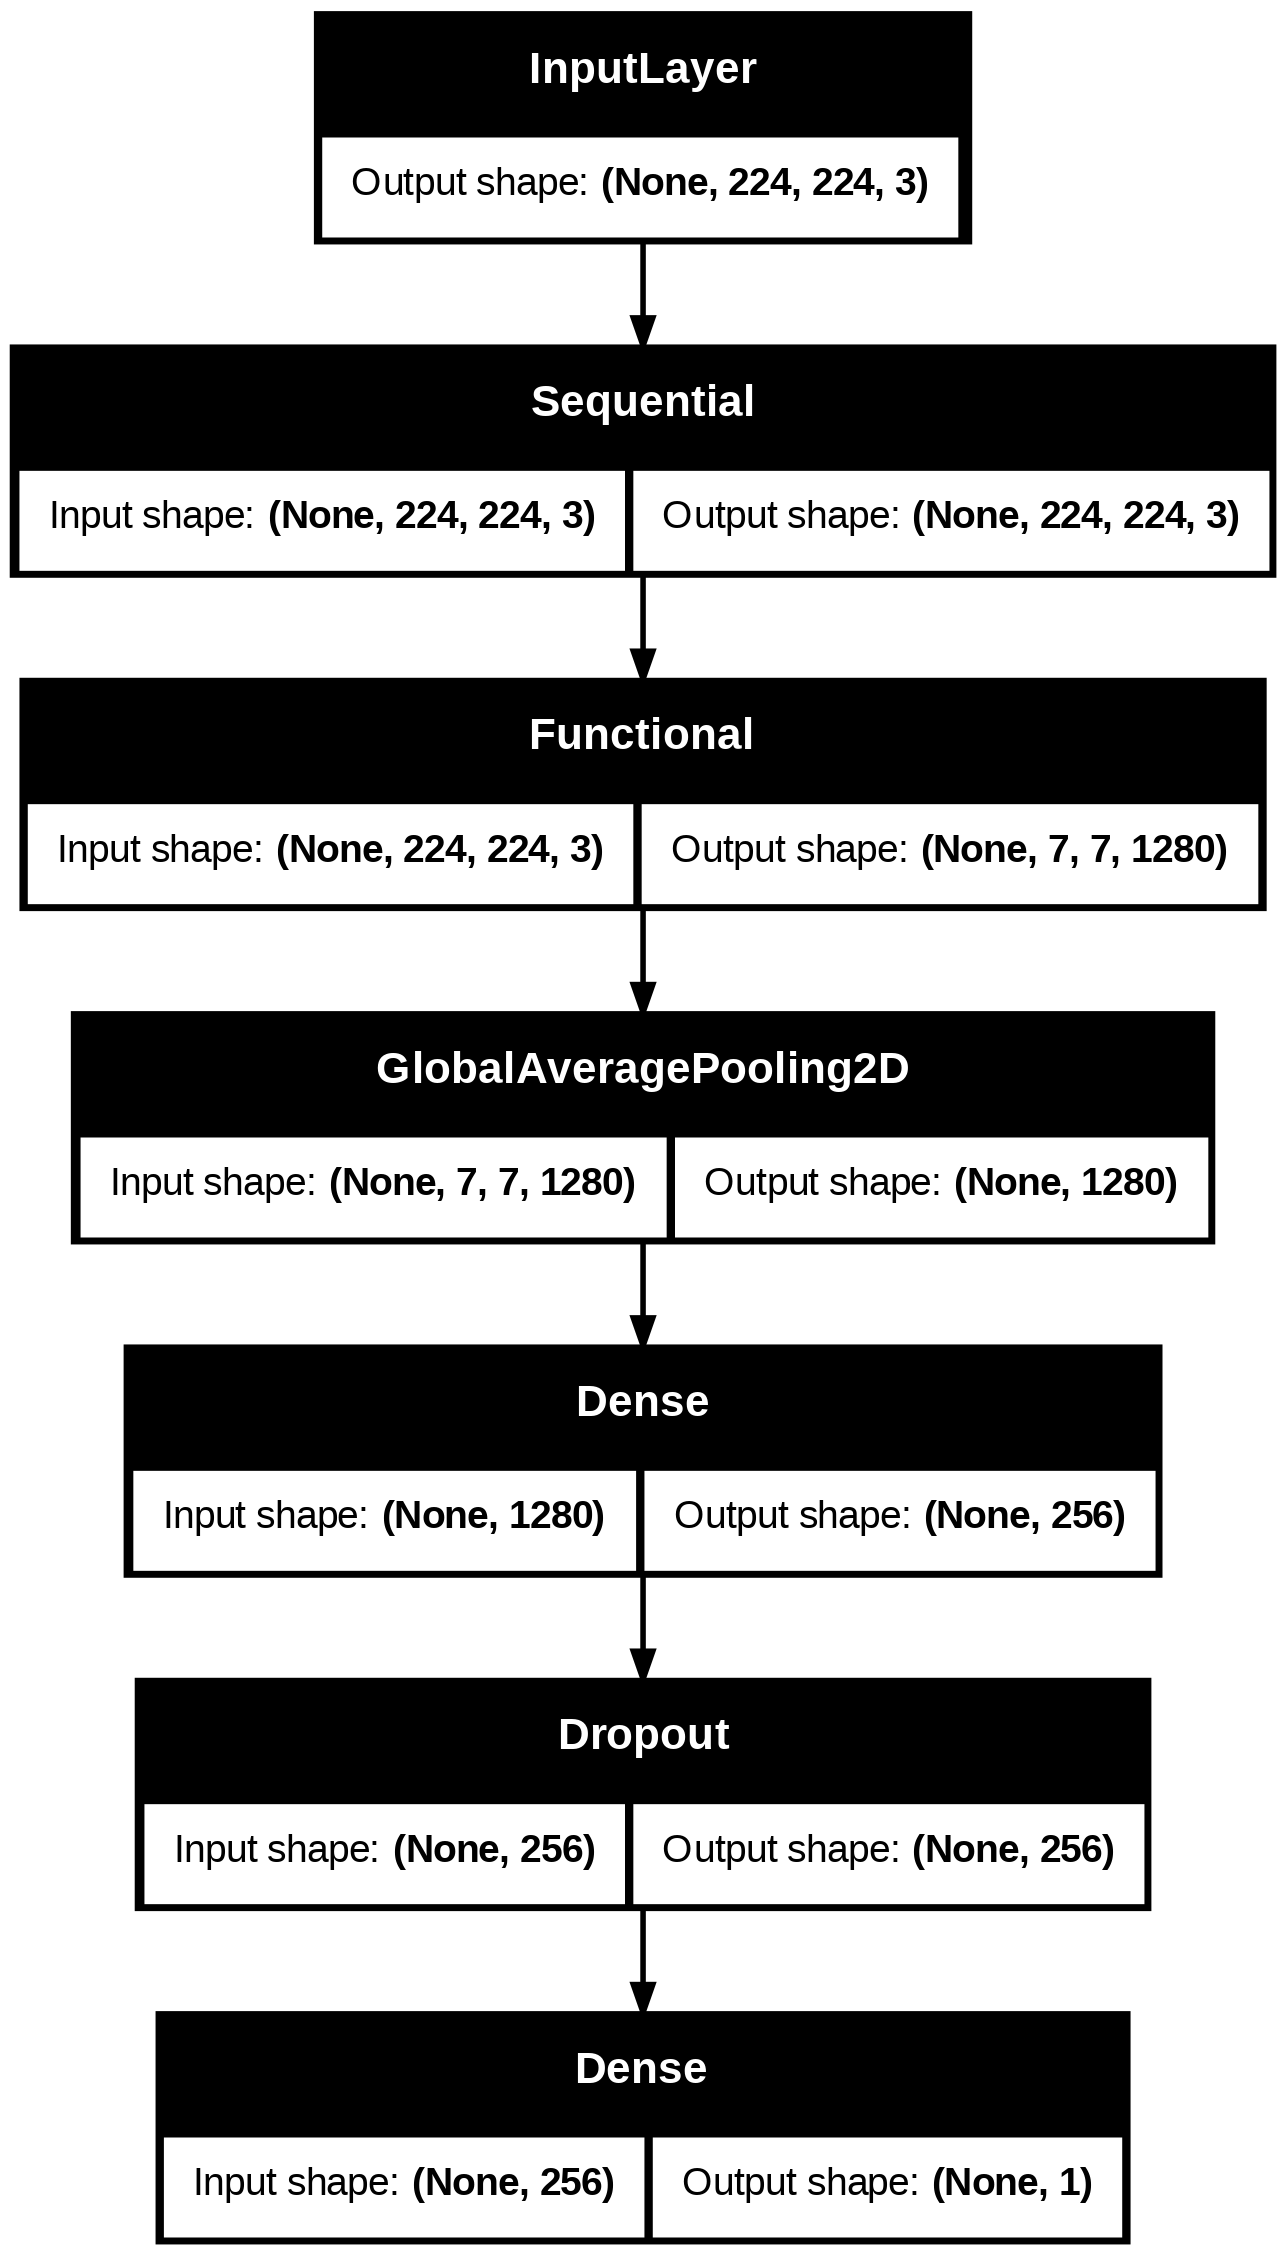

In [ ]:
tf.keras.utils.plot_model(eff_model, show_shapes=True)

In [ ]:
eff_model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:


history_eff1 = eff_model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    callbacks=callbacks
)


Epoch 1/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.5309 - loss: 0.7353 - val_accuracy: 0.7500 - val_loss: 0.6263 - learning_rate: 3.0000e-05
Epoch 2/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6519 - loss: 0.6305 - val_accuracy: 0.8643 - val_loss: 0.5606 - learning_rate: 3.0000e-05
Epoch 3/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7108 - loss: 0.5826 - val_accuracy: 0.8857 - val_loss: 0.5041 - learning_rate: 3.0000e-05
Epoch 4/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7894 - loss: 0.5166 - val_accuracy: 0.9000 - val_loss: 0.4597 - learning_rate: 3.0000e-05
Epoch 5/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8606 - loss: 0.4645 - val_accuracy: 0.9143 - val_loss: 0.4223 - learning_rate: 3.0000e-05
Epoch 6/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8461 - loss: 0.4385 - val_accuracy: 0.9286 - val_loss: 0.3841 - learning_rate: 3.0000e-05
Epoch 7/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9131

In [ ]:
print("Residual best epoch:", np.argmin(history_eff1.history["val_loss"]) + 1)

Residual best epoch: 40


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models


In [ ]:
def build_effnet_v2():

    base = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=(224,224,3)
    )

    # Fine-tune deeper layers from start
    for layer in base.layers[:-50]:
        layer.trainable = False

    inputs = layers.Input(shape=(224,224,3))

    x = get_aug()(inputs)

    x = base(x)

    x = layers.GlobalAveragePooling2D()(x)

    # Stronger classifier
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)

    return model


In [ ]:
eff2__model = build_effnet_v2()
eff2__model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,411,556 (16.83 MB)

 Trainable params: 2,888,337 (11.02 MB)

 Non-trainable params: 1,523,219 (5.81 MB)

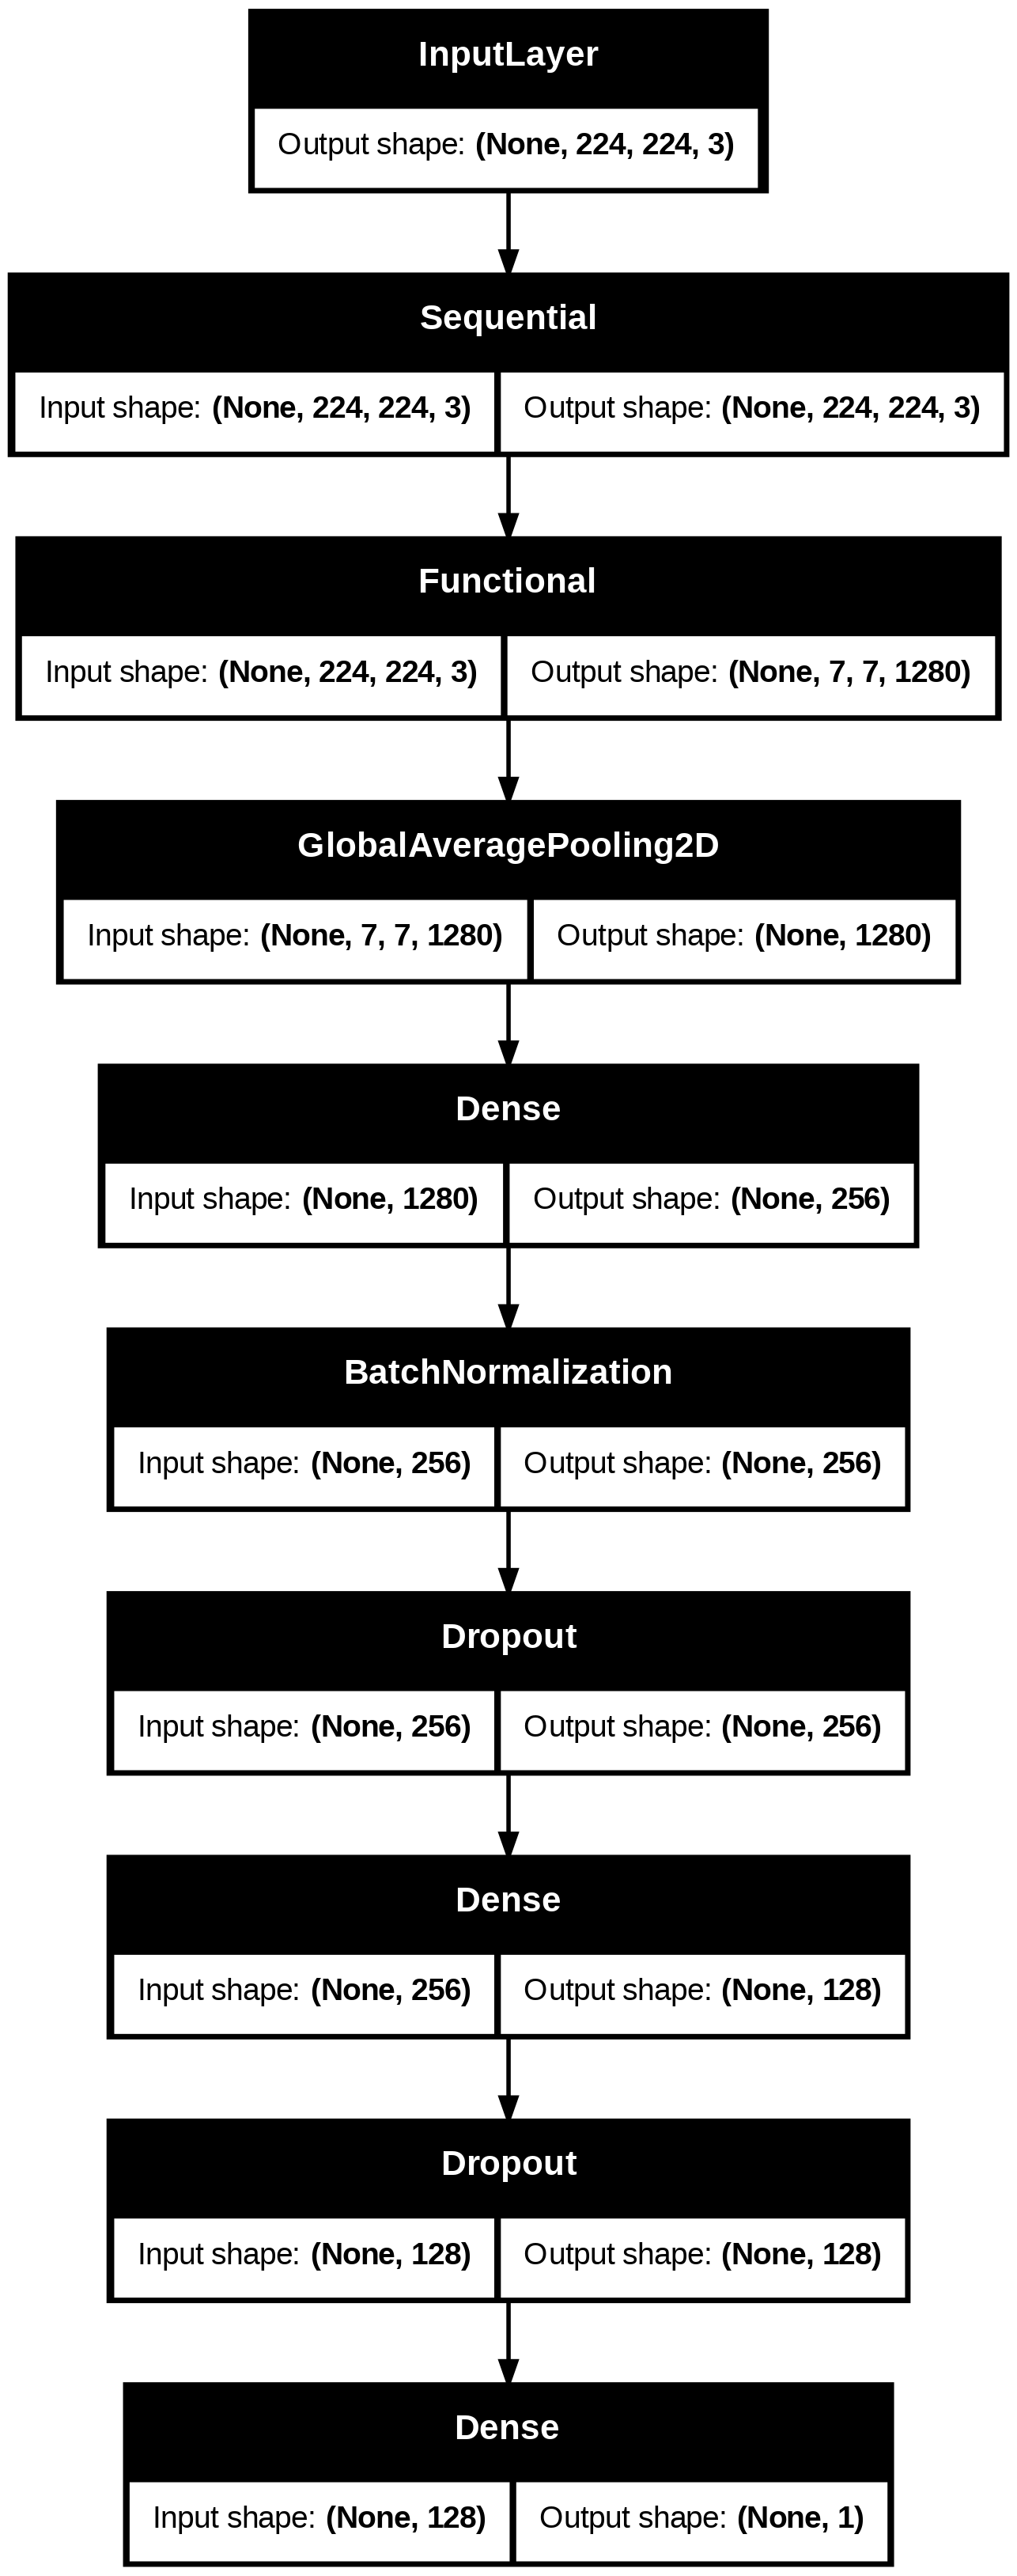

In [ ]:
tf.keras.utils.plot_model(eff2__model, show_shapes=True)


In [ ]:
eff2__model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
callbacks_eff2 = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=6,
        factor=0.3
    )
]


In [ ]:
history__eff2 = eff2__model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks_eff2
)


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.4955 - loss: 1.3353 - val_accuracy: 0.5000 - val_loss: 0.6592 - learning_rate: 3.0000e-05
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5548 - loss: 1.0716 - val_accuracy: 0.6071 - val_loss: 0.5701 - learning_rate: 3.0000e-05
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5929 - loss: 0.9095 - val_accuracy: 0.7500 - val_loss: 0.4622 - learning_rate: 3.0000e-05
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6912 - loss: 0.7011 - val_accuracy: 0.8571 - val_loss: 0.3740 - learning_rate: 3.0000e-05
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7224 - loss: 0.6952 - val_accuracy: 0.9143 - val_loss: 0.2868 - learning_rate: 3.0000e-05
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7579 - loss: 0.5280 - val_accuracy: 0.9214 - val_loss: 0.2315 - learning_rate: 3.0000e-05
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8013

In [ ]:
print("Eff2 best epoch:",
      np.argmin(history__eff2.history["val_loss"]) + 1)


Eff2 best epoch: 20


In [ ]:
def model_info(model, name):
    print(f"\n{name}")
    print("Total layers:", len(model.layers))
    print("Trainable layers:",
          np.sum([layer.trainable for layer in model.layers]))



In [ ]:
model_info(cnn_model, "CNN")
model_info(res_model, "Residual")
model_info(eff_model, "EfficientNet")
model_info(eff2__model, "EfficientNet V2")



CNN
Total layers: 12
Trainable layers: 12

Residual
Total layers: 33
Trainable layers: 33

EfficientNet
Total layers: 7
Trainable layers: 6

EfficientNet V2
Total layers: 10
Trainable layers: 10


In [ ]:
def activation_summary(model):
    acts = [layer.activation.__name__
            for layer in model.layers
            if hasattr(layer, "activation")]
    print(set(acts))


In [ ]:
activation_summary(cnn_model)
activation_summary(res_model)
activation_summary(eff1_model)
activation_summary(eff2__model)

{'sigmoid', 'relu'}
{'sigmoid', 'relu', 'linear'}
{'sigmoid', 'relu'}
{'sigmoid', 'relu'}


In [ ]:
print("Loss:", cnn_model.loss)
print("Optimizer:", cnn_model.optimizer)
print("Batch size:", BATCH_SIZE)


Loss: binary_crossentropy
Optimizer: <keras.src.optimizers.adam.Adam object at 0x7d4a96f84740>
Batch size: 8


In [ ]:
print("CNN epochs:", len(history_cnn.history["loss"]))
print("Residual epochs:", len(history_res.history["loss"]))
print("Eff1 epochs:", len(history_eff1.history["loss"]))
print("Eff2 epochs:", len(history__eff2.history["loss"]))


CNN epochs: 18
Residual epochs: 29
Eff1 epochs: 40
Eff2 epochs: 20


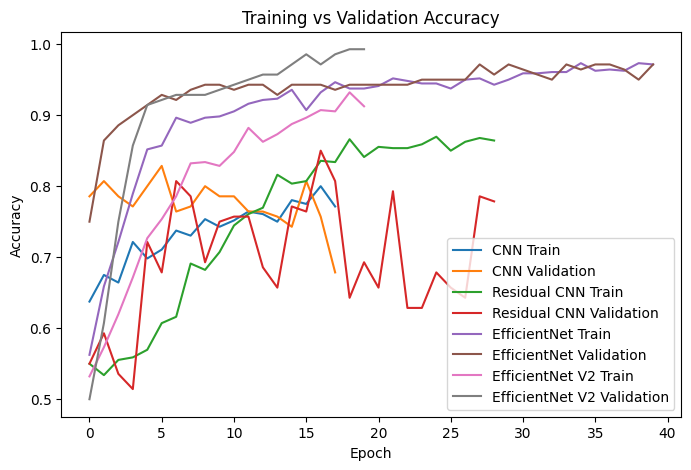

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history_cnn.history["accuracy"], label="CNN Train")
plt.plot(history_cnn.history["val_accuracy"], label="CNN Validation")

plt.plot(history_res.history["accuracy"], label="Residual CNN Train")
plt.plot(history_res.history["val_accuracy"], label="Residual CNN Validation")

plt.plot(history_eff1.history["accuracy"], label="EfficientNet Train")
plt.plot(history_eff1.history["val_accuracy"], label="EfficientNet Validation")

plt.plot(history__eff2.history["accuracy"], label="EfficientNet V2 Train")
plt.plot(history__eff2.history["val_accuracy"], label="EfficientNet V2 Validation")

plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


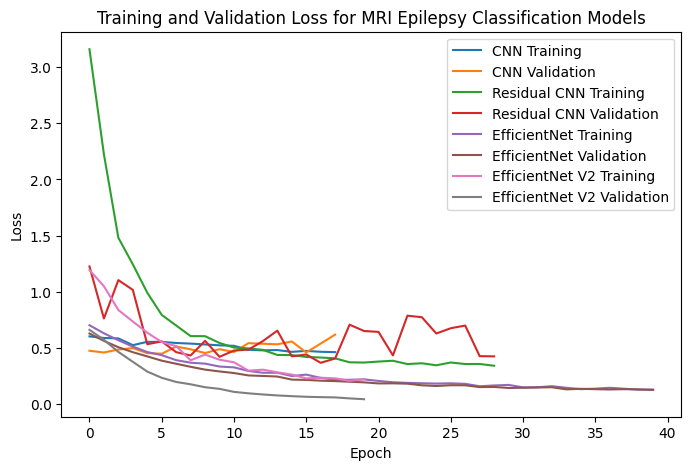

In [ ]:
plt.figure(figsize=(8,5))

# CNN
plt.plot(history_cnn.history["loss"], label="CNN Training")
plt.plot(history_cnn.history["val_loss"], label="CNN Validation")

# Residual Network
plt.plot(history_res.history["loss"], label="Residual CNN Training")
plt.plot(history_res.history["val_loss"], label="Residual CNN Validation")

# EfficientNet
plt.plot(history_eff1.history["loss"], label="EfficientNet Training")
plt.plot(history_eff1.history["val_loss"], label="EfficientNet Validation")

# EfficientNet V2 (your improved model)
plt.plot(history__eff2.history["loss"], label="EfficientNet V2 Training")
plt.plot(history__eff2.history["val_loss"], label="EfficientNet V2 Validation")

plt.legend()
plt.title("Training and Validation Loss for MRI Epilepsy Classification Models")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()



In [ ]:
def get_preds(model):
    preds = model.predict(val_data)
    return preds


In [ ]:
cnn_preds = get_preds(cnn_model)
res_preds = get_preds(res_model)
eff_preds = get_preds(eff_model)
eff2_preds = get_preds(eff2__model)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step


In [ ]:
y_true = []

for _, labels in val_data:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)


In [ ]:
def binary(preds):
    return (preds > 0.5).astype(int)

cnn_bin = binary(cnn_preds)
res_bin = binary(res_preds)
eff_bin = binary(eff_preds)
eff2_bin = binary(eff2_preds)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

def metrics(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_true, y_pred)
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)

    print(f"\n{name}")
    print("Accuracy:", acc)
    print("Sensitivity:", sens)
    print("Specificity:", spec)

    return cm, acc, sens, spec


In [ ]:
cm_cnn, acc_cnn, sens_cnn, spec_cnn = metrics(y_true, cnn_bin, "CNN")
cm_res, acc_res, sens_res, spec_res = metrics(y_true, res_bin, "Residual")
cm_eff, acc_eff, sens_eff, spec_eff = metrics(y_true, eff_bin, "EfficientNet")
cm_eff2, acc_eff2, sens_eff2, spec_eff2 = metrics(y_true, eff2_bin, "EfficientNetV2")



CNN
Accuracy: 0.8285714285714286
Sensitivity: 0.7428571428571429
Specificity: 0.9142857142857143

Residual
Accuracy: 0.8214285714285714
Sensitivity: 0.7285714285714285
Specificity: 0.9142857142857143

EfficientNet
Accuracy: 0.9714285714285714
Sensitivity: 0.9571428571428572
Specificity: 0.9857142857142858

EfficientNetV2
Accuracy: 0.9928571428571429
Sensitivity: 0.9857142857142858
Specificity: 1.0


In [ ]:
import seaborn as sns

def plot_cm(cm, title):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["Healthy","Epilepsy"],
                yticklabels=["Healthy","Epilepsy"])
    plt.title(title)
    plt.show()


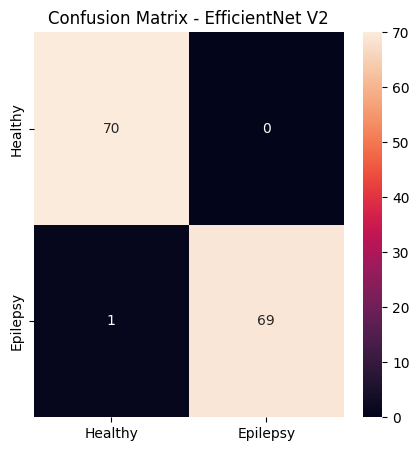

In [ ]:
plot_cm(cm_eff2, "Confusion Matrix - EfficientNet V2")


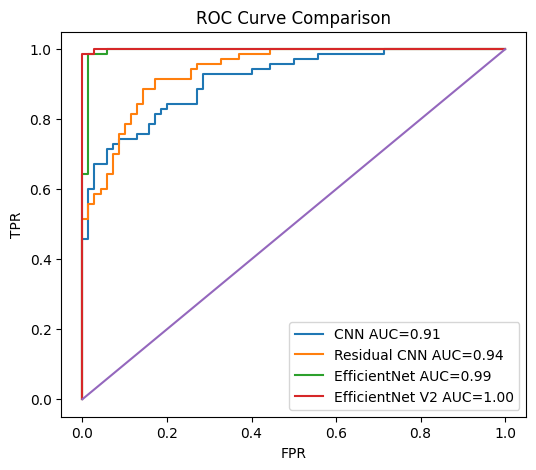

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(6,5))

def roc_plot(preds, label):
    fpr, tpr, _ = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} AUC={roc_auc:.2f}")

roc_plot(cnn_preds, "CNN")
roc_plot(res_preds, "Residual CNN")
roc_plot(eff_preds, "EfficientNet")
roc_plot(eff2_preds, "EfficientNet V2")

plt.plot([0,1],[0,1])
plt.legend()
plt.title("ROC Curve Comparison")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


In [ ]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["CNN","Residual CNN","EfficientNet","EfficientNet V2"],
    "Accuracy": [acc_cnn, acc_res, acc_eff, acc_eff2],
    "Sensitivity": [sens_cnn, sens_res, sens_eff, sens_eff2],
    "Specificity": [spec_cnn, spec_res, spec_eff, spec_eff2]
})

results


,Model,Accuracy,Sensitivity,Specificity
0,CNN,0.828571,0.742857,0.914286
1,Residual CNN,0.821429,0.728571,0.914286
2,EfficientNet,0.971429,0.957143,0.985714
3,EfficientNet V2,0.992857,0.985714,1.000000


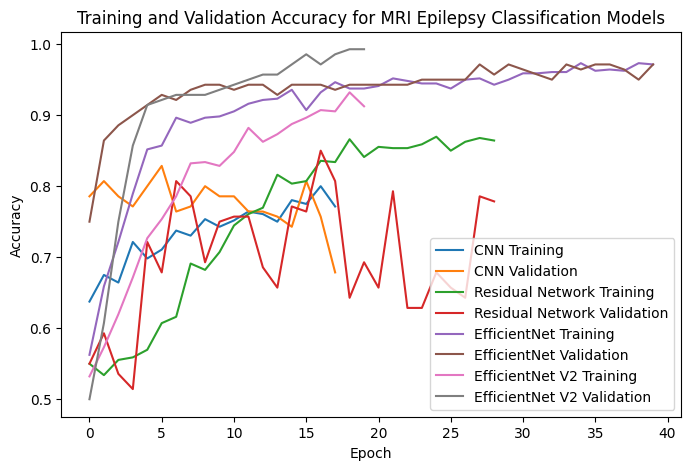

In [ ]:
plt.figure(figsize=(8,5))

# CNN
plt.plot(history_cnn.history["accuracy"], label="CNN Training")
plt.plot(history_cnn.history["val_accuracy"], label="CNN Validation")

# Residual Network
plt.plot(history_res.history["accuracy"], label="Residual Network Training")
plt.plot(history_res.history["val_accuracy"], label="Residual Network Validation")

# EfficientNet
plt.plot(history_eff1.history["accuracy"], label="EfficientNet Training")
plt.plot(history_eff1.history["val_accuracy"], label="EfficientNet Validation")

# EfficientNet V2
plt.plot(history__eff2.history["accuracy"], label="EfficientNet V2 Training")
plt.plot(history__eff2.history["val_accuracy"], label="EfficientNet V2 Validation")

plt.legend()
plt.title("Training and Validation Accuracy for MRI Epilepsy Classification Models")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

auc_eff2 = roc_auc_score(y_true, eff2_preds)
print("EfficientNet V2 AUC:", auc_eff2)


EfficientNet V2 AUC: 0.9995918367346939


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, eff2_bin))


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        70
         1.0       1.00      0.99      0.99        70

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140



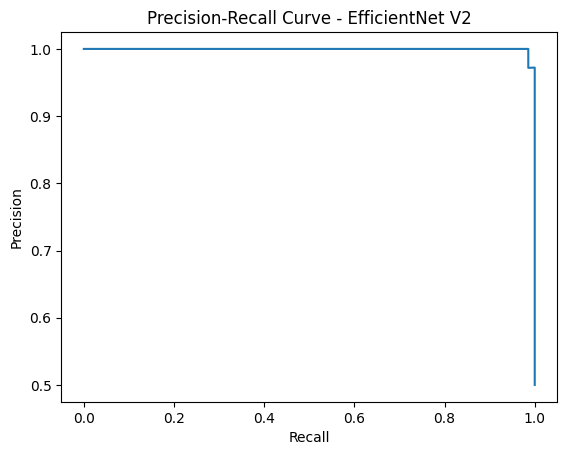

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, eff2_preds)

plt.plot(recall, precision)
plt.title("Precision-Recall Curve - EfficientNet V2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


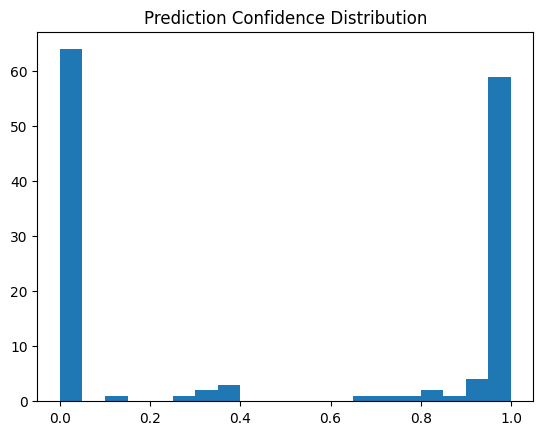

In [ ]:
plt.hist(eff2_preds, bins=20)
plt.title("Prediction Confidence Distribution")
plt.show()


In [ ]:
import os

models_path = "/content/drive/MyDrive/MODELS"
os.makedirs(models_path, exist_ok=True)

print("MODELS folder ready ✅")


MODELS folder ready ✅


In [ ]:
cnn_model.save(f"{models_path}/cnn_baseline.h5")

res_model.save(f"{models_path}/residual_cnn.h5")

eff_model.save(f"{models_path}/efficientnet_transfer_learning.h5")

eff2_model.save(f"{models_path}/efficientnet_v2_finetuned.h5")

print("All models saved successfully ✅")


All models saved successfully ✅
